# Demo Regression

In this notebook, we will look showcase how to implement a JAX trainer for research purposes. We will use the documentation from the [uvadlc notebooks](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/guide4/Research_Projects_with_JAX.html) and adapt this to the libraries I would like to use:

* jax
* equinox
* optax

In [2]:
import pytorch_lightning
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".home"])
nn_model = "/Users/eman/code_projects/eqx-nerf"

# append to path
sys.path.append(str(root))
sys.path.append(str(nn_model))

In [3]:
# Standard libraries
import os
import sys
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union
import json
import time
from tqdm.auto import tqdm
import numpy as np
from copy import copy
from glob import glob
from collections import defaultdict

# JAX/Flax
# If you run this code on Colab, remember to install flax and optax
# !pip install --quiet --upgrade flax optax
import jax
import jax.numpy as jnp
from jax import random
from flax import linen as nn
import optax
import equinox as eqx

# PyTorch for data loading
import torch
import torch.utils.data as data

# Logging with Tensorboard or Weights and Biases
# If you run this code on Colab, remember to install pytorch_lightning
# !pip install --quiet --upgrade pytorch_lightning
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

## Imports for plotting
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import seaborn as sns
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
%matplotlib inline
%load_ext autoreload
%autoreload 2

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_74899/3385202938.py:35: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


## Data

In [4]:
def target_function(x):
    return np.sin(x * 10.0)

class RegressionDataset(data.Dataset):

    def __init__(self, num_points, seed):
        super().__init__()
        rng = np.random.default_rng(seed)
        self.x = rng.uniform(low=-1.0, high=1.0, size=num_points)
        self.y = target_function(self.x)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx:idx+1], self.y[idx:idx+1]

In [5]:
train_set = RegressionDataset(num_points=1000, seed=42)
val_set = RegressionDataset(num_points=200, seed=43)
test_set = RegressionDataset(num_points=500, seed=44)

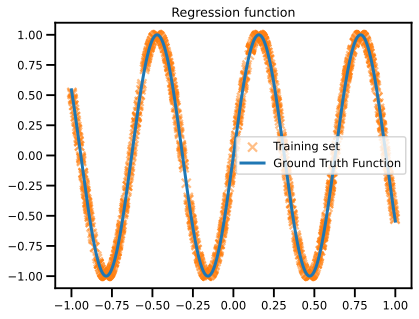

In [6]:

x = np.linspace(-1, 1, 1000)
plt.scatter(train_set.x, train_set.y, color='C1', marker='x', alpha=0.5, label='Training set')
plt.plot(x, target_function(x), linewidth=3.0, label='Ground Truth Function')
plt.legend()
plt.title('Regression function')
plt.show()

In [7]:
import jax
from torch.utils.data import DataLoader
from eqx_trainer import numpy_collate


class NumpyLoader(DataLoader):
    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=False,
        sampler=None,
        batch_sampler=None,
        num_workers=0,
        pin_memory=False,
        drop_last=False,
        timeout=0,
        worker_init_fn=None,
        collate_fn=numpy_collate,
        persistent_workers=False,
    ):
        super(self.__class__, self).__init__(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=drop_last,
            timeout=timeout,
            worker_init_fn=worker_init_fn,
            persistent_workers=persistent_workers,
        )

## DataModule

In [8]:
import pytorch_lightning as pl

class RegressionDataModule(pl.LightningDataModule):
    def __init__(
            self, num_train: int=1000, num_valid: int=200, num_test: int=500, seed=42,
            num_workers: int=0, batch_size: int=32):
        super().__init__()
        self.num_train = num_train
        self.num_valid = num_valid
        self.num_test = num_test
        self.seed = seed
        self.num_workers = num_workers
        self.batch_size = batch_size

    def setup(self, stage: str=None) -> None:
        self.train_set = RegressionDataset(num_points=self.num_train, seed=42)
        self.val_set = RegressionDataset(num_points=self.num_valid, seed=43)
        self.test_set = RegressionDataset(num_points=self.num_test, seed=44)

    def train_dataloader(self):
        return data.DataLoader(
            dataset=self.train_set,
            batch_size=self.batch_size,
            collate_fn=numpy_collate,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=self.val_set,
            batch_size=self.batch_size,
            collate_fn=numpy_collate,
            num_workers=self.num_workers,
            shuffle=False,
        )
    def test_dataloader(self):
        return data.DataLoader(
            dataset=self.test_set,
            batch_size=self.batch_size,
            collate_fn=numpy_collate,
            num_workers=self.num_workers,
            shuffle=False,
        )



In [9]:
dm = RegressionDataModule(num_train=1_000, num_valid=200, num_test=500,
                          batch_size=128)
dm.setup()

In [10]:
for ibatch in tqdm(dm.train_dataloader()):
    break

print(ibatch[0].shape, ibatch[1].shape, type(ibatch[0]))

  0%|          | 0/8 [00:00<?, ?it/s]

(128, 1) (128, 1) <class 'numpy.ndarray'>


In [83]:
from dataclasses import dataclass


@dataclass
class Params:
    width_size: int = 32
    depth: int = 2
    lr: float = 5e-3
    num_epochs: int = 500
    

In [84]:
params = Params()

## Model

In [85]:
import equinox as eqx
from equinox.nn.linear import Identity
from eqx_nerf import SirenNet
import jax.random as jrandom


def init_model(width_size: int=32, depth: int=2):
    
    model = eqx.nn.MLP(
        in_size=1, out_size=1, 
        width_size=width_size, depth=depth,
        # activation=eqx.nn.Lambda(jax.nn.silu),
        activation=eqx.nn.activations.PReLU(),
        final_activation=Identity(),
        key=jrandom.PRNGKey(123)
    )
    return model

In [86]:
import equinox as eqx
from equinox.nn.linear import Identity
from eqx_nerf import SirenNet
import jax.random as jrandom

model = init_model(
    width_size=params.width_size, 
    depth=params.depth
)

# check output of models
out = jax.vmap(model)(ibatch[0])

assert out.shape == ibatch[0].shape
eqx.tree_pprint(model)

MLP(
  layers=(
    Linear(
      weight=f32[32,1],
      bias=f32[32],
      in_features=1,
      out_features=32,
      use_bias=True
    ),
    Linear(
      weight=f32[32,32],
      bias=f32[32],
      in_features=32,
      out_features=32,
      use_bias=True
    ),
    Linear(
      weight=f32[1,32],
      bias=f32[1],
      in_features=32,
      out_features=1,
      use_bias=True
    )
  ),
  activation=PReLU(negative_slope=f32[]),
  final_activation=Identity(),
  in_size=1,
  out_size=1,
  width_size=32,
  depth=2
)


## Optimizer (+ Learning Rate)

In [87]:
import optax

def init_optimizer(num_steps_per_epoch: int, 
                   lr: float=4e-4, 
                   num_epochs: int=500, 
                   **kwargs
                  ):
    # optimizer = optax.adamw(learning_rate=learning_rate)
    lr_scheduler = optax.warmup_cosine_decay_schedule(
        init_value=kwargs.get("start_lr", 0.0),
        peak_value=lr,
        warmup_steps=kwargs.get("warmup_steps", 100),
        decay_steps=int(num_epochs * num_steps_per_epoch),
        end_value=kwargs.get("eta", 0.01) * lr
    )
    
    return optax.adamw(lr_scheduler)

In [88]:
optimizer = init_optimizer(
    num_epochs=params.num_epochs,
    lr=params.lr,
    num_steps_per_epoch=len(dm.train_dataloader())
)

In [89]:
type(optimizer)

optax._src.base.GradientTransformation

## Loggers

In [101]:
from eqx_trainer._src.utils import dataclass_to_dict

In [103]:
config_dict = dataclass_to_dict(params)
config_dict

{'width_size': 32, 'depth': 2, 'lr': 0.005, 'num_epochs': 500}

In [107]:
import wandb
wandb.finish()

In [108]:
loggers = list()

log_dir = "/Users/eman/code_projects/logs"
wandb_logger = WandbLogger(
    mode="online",
    save_dir=log_dir,
    entity="ige",
    project="jax4eo",
    config=config_dict
)


## Trainer Module

In [109]:
import glob
import os
from pathlib import Path

from eqx_trainer import TrainerModule
from eqx_trainer._src.callbacks import wandb_model_artifact

class RegressorTrainer(TrainerModule):
    def __init__(self,
                 model,
                 optimizer,
                 pl_logger,
                 **kwargs):
        super().__init__(
            model=model, 
            optimizer=optimizer, 
            pl_logger=pl_logger,
            log_dir=pl_logger.experiment.dir,
            **kwargs
        )

    def create_functions(self):

        @eqx.filter_value_and_grad
        def mse_loss(model, batch):
            x, y = batch
            pred = jax.vmap(model)(x)
            loss = jnp.mean((y - pred)**2)
            return loss
        
        def train_step(state, batch):
            
            loss, grads = mse_loss(state.params, batch)
            state = state.update_state(state, grads)
            metrics = {"loss": loss}
            return state, loss, metrics
            
        
#         def train_step(model, opt_state, batch):
            
#             loss, grads = mse_loss(model, batch)
#             model, opt_state = self.apply_updates(model, opt_state, grads)
#             metrics = {"loss": loss}
#             return model, opt_state, loss, metrics


        def eval_step(model, batch):
            loss, _ = mse_loss(model, batch)
            return {"loss": loss}

        return train_step, eval_step
    
    
    def on_training_end(self,):
        

        
        if self.pl_logger:
            save_dir = Path(self.log_dir).joinpath(self.save_name)
            self.save_model(save_dir)
            wandb_model_artifact(self)
            self.pl_logger.finalize("success")
        
        


In [110]:
seed = 123
debug = False
enable_progress_bar = False

trainer = RegressorTrainer(
    model, 
    optimizer, 
    seed=seed, 
    debug=debug, 
    enable_progress_bar=enable_progress_bar,
    pl_logger=wandb_logger
)


In [111]:
%%time


metrics = trainer.train_model(dm, 500)

Epochs: 500 | Loss: 1.581e-04: 100%|██████████| 500/500 [00:07<00:00, 70.32it/s]


CPU times: user 6.91 s, sys: 251 ms, total: 7.17 s
Wall time: 7.3 s


In [112]:
metrics

{'train/loss': 0.00015810393961146474, 'epoch_time': 0.010275840759277344}

In [113]:
# trainer.save_model("checkpoint_model.ckpt")
# trainer.save_state("checkpoint_state.ckpt")

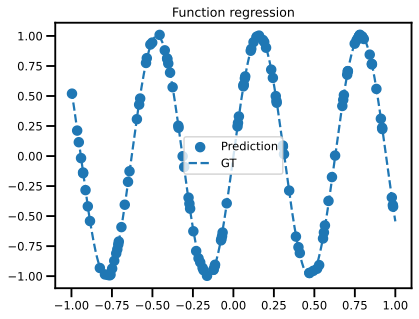

In [114]:
x = np.linspace(-1, 1, 1000)[:,None]
y_pred = jax.vmap(trainer.model)(ibatch[0])
plt.scatter(ibatch[0], y_pred, label='Prediction')
plt.plot(x, target_function(x), '--', label='GT')
plt.title('Function regression')
plt.legend()
plt.show()

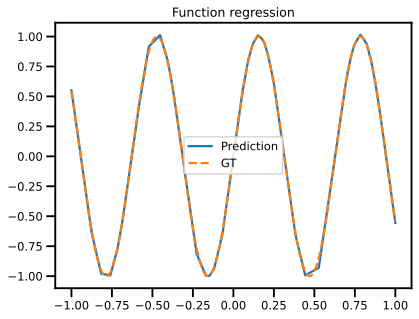

In [115]:
x = np.linspace(-1, 1, 1000)[:,None]
y_pred = trainer.model_batch(x)
plt.plot(x, y_pred, label='Prediction')
plt.plot(x, target_function(x), '--', label='GT')
plt.title('Function regression')
plt.legend()
plt.show()

In [116]:
wandb.finish()

epoch_time,▄▁▁▂▃▄▆▃▂▄▂█▃▁▂▆▃▂▅▁▂▂▁▂▇▂▇▄▂▂▃▁▅▂▂▂▂▁▅▃
train/loss,██▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val/loss,██▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_time,0.01028
train/loss,0.00016
trainer/global_step,500
val/loss,0.00014


## Loading CheckPoints


* Pre-Trained Models
* Training "More"

In [142]:
from dataclasses import dataclass


@dataclass
class Params:
    width_size: int = 32
    depth: int = 2
    lr: float = 5e-3
    num_epochs: int = 1_000
    

In [143]:
params = Params()

config_dict = dataclass_to_dict(params)
config_dict

{'width_size': 32, 'depth': 2, 'lr': 0.005, 'num_epochs': 1000}

In [122]:
from eqx_trainer._src.utils.wandb import load_wandb_run_config, download_wandb_artifact_model


We can look at a previous run on weights and biases!
```
ige/jax4eo/p017leep
```

In [129]:
entity = "ige"
project = "jax4eo"
id = "p017leep"

# load old config
old_config = load_wandb_run_config(entity=entity, project=project, id=id)

old_config

{'lr': 0.005, 'depth': 2, 'num_epochs': 500, 'width_size': 32}

In [124]:
loggers = list()

log_dir = "/Users/eman/code_projects/logs"
wandb_logger = WandbLogger(
    mode="online",
    save_dir=log_dir,
    entity="ige",
    project="jax4eo",
    config=config_dict
)


In [133]:
wandb_logger.experiment.config.update({
    "width_size": old_config["width_size"],
    "depth": old_config["depth"]
})

In [134]:
entity = "ige"
project = "jax4eo"
id = "p017leep"
reference = "experiments-ckpts:v17"
ckpt_name = "checkpoint_model"

# get checkpoint filename
ckpt_file = download_wandb_artifact_model(entity, project, reference, "checkpoint_model")

ckpt_file

wandb:   1 of 1 files downloaded.  


PosixPath('artifacts/experiments-ckpts:v17/checkpoint_model.ckpt')

In [135]:
model = init_model(
    width_size=old_config["width_size"],
    depth=old_config["depth"]
)


optimizer = init_optimizer(
    num_epochs=config_dict["num_epochs"],
    lr=config_dict["lr"],
    num_steps_per_epoch=len(dm.train_dataloader())
)

In [144]:
seed = 123
debug = False
enable_progress_bar = False

trainer = RegressorTrainer(
    model, 
    optimizer, 
    seed=seed, 
    debug=debug, 
    enable_progress_bar=enable_progress_bar,
    pl_logger=wandb_logger,
)

trainer.load_model(ckpt_file)

In [145]:
%%time


metrics = trainer.train_model(dm, 500)

Epochs: 500 | Loss: 1.264e-04: 100%|██████████| 500/500 [00:06<00:00, 73.31it/s]


CPU times: user 6.65 s, sys: 222 ms, total: 6.87 s
Wall time: 7.03 s


In [146]:
# trainer.save_model("checkpoint_model.ckpt")

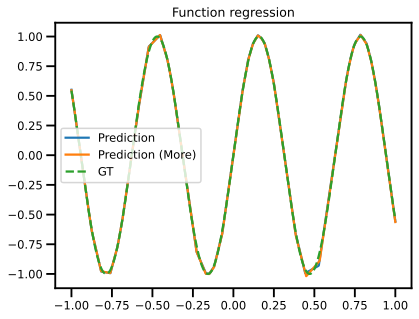

In [147]:
x = np.linspace(-1, 1, 1000)[:,None]
y_pred_more = trainer.model_batch(x)
plt.plot(x, y_pred, label='Prediction')
plt.plot(x, y_pred_more, label='Prediction (More)')
plt.plot(x, target_function(x), '--', label='GT')
plt.title('Function regression')
plt.legend()
plt.show()

In [148]:
wandb.finish()

epoch_time,▅▅▆▄▄▃▆▅▄█▄▂▆▂▆▄▂▅▁▃▆▄▃▂▂▂▃█▃▅▁▁▅▃▁▄▃▁▂▄
train/loss,▆█▆▅▆▄▃▅▂▃▆▂▄▃▃▁▂▂▁▂▅▆▅▆▅▃▄▄▂▃▅▂▂▂▄▂▂▁▁▂
trainer/global_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
val/loss,▄▆▅▂▄▃▃▄▂▃▇▂▅▅▃▁▁▃▂▂▃█▃▃▅▅▂▄▂▃▃▂▂▂▂▁▃▁▁▂
epoch_time,0.00938
train/loss,0.00013
trainer/global_step,500
val/loss,0.0001
